# 練習課題1
[前提]  
見習い期間中のお試しタスクとしての練習課題です。  
  
[タスク目的]
- お試しタスクを解く事で、タスクやプロジェクトに対する理解力を向上
- タスクやプロジェクトに対する進め方を学習する事で、新規プロジェクトにアサインされた際に適用出来るようにする事
- 構造化データの扱いに慣れる事
- スクレイピングをマスターする
  
[課題]  
不動産業者が保有している物件データを活用し、特徴を分析し、可視化せよ  
  
[アウトプットイメージ]  
1. 参考リンクをもとに、SUUMOの中古物件情報(項目は以下）を所得し、加工した状態でCSVで出力
2. 加工後の情報に対して、地区や駅、価格など分布図を作成し可視化せよ（可視化についてはいくつか種類あるので、仮説で設定してOK）
---- 
フィールド名  説明  
カテゴリ    中古マンション or 中古一戸建て  
販売価格    販売価格  
所在地   物件所在地  
区 区  
沿線  物件最寄沿線  
最寄駅   物件最寄駅  
徒歩（分） 物件から最寄駅までの徒歩時間。バスの場合は物件からバス停までの時間  
バス（分） バス乗車時間。バスを使用しない場合は0  
土地面積    土地面積。中古マンションは建物面積＝土地面積とする  
建物面積    中古一戸建てもしくは中古マンションの建物面積  
バルコニー バルコニー面積。中古マンションのみ使用  
間取り   物件の間取り  
築年数   築年月から計算   
----
***取得できれば***  
向き（日当たり）  
駐車場有無  
庭有無  
周辺環境  
-----
[コードレビュー]  
岩崎くんに依頼  
  
[期限]  
1週間  
  
[参考リンク]  
https://www.gis-py.com/entry/scraping-suumo  
https://qiita.com/0yan/items/90800b03cc38e322d920  

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import os
import datetime
import re
import csv
import pandas as pd
import openpyxl
import urllib.request

## スクレイピング

In [2]:
url_list = ["https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=021&ta=14"  \
            "&jspIdFlg=patternShikugun&sc=14101&sc=14102&sc=14103&sc=14104&sc=14105&sc=14106"  \
            "&sc=14107&sc=14108&sc=14109&sc=14110&sc=14111&sc=14112&sc=14113&sc=14114"  \
            "&sc=14115&sc=14116&sc=14117&sc=14118&kb=1&kt=9999999&tb=0&tt=9999999&hb=0"  \
            "&ht=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&pn={}",

            "https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=14" \
            "&jspIdFlg=patternShikugun&sc=14101&sc=14102&sc=14103&sc=14104&sc=14105&sc=14106" \
            "&sc=14107&sc=14108&sc=14109&sc=14110&sc=14111&sc=14112&sc=14113&sc=14114" \
            "&sc=14115&sc=14116&sc=14117&sc=14118&kb=1&kt=9999999&mb=0&mt=9999999" \
            "&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&pn={}"]

In [3]:
# 収集するデータのカラム
cols = ["カテゴリ", "販売価格", "所在地", "区", "沿線", "最寄駅", "徒歩（分）", "バス（分）",
        "土地面積", "建物面積", "バルコニー", "間取り", "築年数"]

In [4]:
def identify_floor_plan(floor_plan):
    # 間取りの種類が多すぎるのでまとめる
    if floor_plan.find("ワンルーム") > -1:
        floor_plan = "1K"
    if floor_plan.find("+") > -1:
        floor_plan = floor_plan[:floor_plan.find("+")]
    if floor_plan.find("LK") > -1:
        floor_plan = floor_plan[0:1] + "LDK"
    if floor_plan.find("LL") > -1 or \
       floor_plan.find("DD") > -1 or \
       floor_plan.find("KK") > -1:
        floor_plan = floor_plan = floor_plan[0:1] + "LDK"

    return floor_plan

In [25]:
#失敗
def convert_price(price):
    #「〇万円※権利金含む」の処理
    if price.find("※") > -1:
        price = price[:price.find("※")]
    
    #「○○万円～○○万円」の処理
    if price.find("～") > -1:
        price = price[price.find("～") + 1:]
        #「億」が含まれる場合
        if price.find("億") > -1:
            #「1億円」ジャストのような場合の処理
            if price.find("万") == -1:
                price = int(price[:price.find("億")]) * 100000000
            else:
                oku = int(price[:price.find("億")]) * 100000000
                price = oku + int(price[price.find("億") + 1:-2]) * 10000
        #「億」が含まれない場合
        else:
            price = int(price[:price.find("万円")]) * 10000
            
    else:#数値に変換
        #「億」が含まれる場合
        if price.find("億") > -1:
            #「1億円」ジャストのような場合の処理
            if price.find("万") == -1:
                price = int(price[:price.find("億")]) * 100000000
            else:
                oku = int(price[:price.find("億")]) * 100000000
                price = oku + int(price[price.find("億") + 1:-2]) * 10000
         #「億」が含まれない場合
        else:
            price = int(price[:-2]) * 10000
            
    return price

In [5]:
#訂正版
def convert_price(price):
    #「〇万円※権利金含む」の処理
    if price.find("※") > -1:
        price = price[:price.find("※")]
    
    #「○○万円・○○万円」の処理
    if price.find("・") > -1:
        price = price[:price.find("・")]
    
    #「○○万円～○○万円」の処理
    if price.find("～") > -1:
        price = price[price.find("～") + 1:]
        #「億」が含まれる場合
        if price.find("億") > -1:
            #「1億円」ジャストのような場合の処理
            if price.find("万") == -1:
                price = int(price[:price.find("億")]) * 100000000
            else:
                oku = int(price[:price.find("億")]) * 100000000
                price = oku + int(price[price.find("億") + 1:-2]) * 10000
        #「億」が含まれない場合
        else:
            price = int(price[:price.find("万円")]) * 10000
            
    else:#数値に変換
        #「億」が含まれる場合
        if price.find("億") > -1:
            #「1億円」ジャストのような場合の処理
            if price.find("万") == -1:
                price = int(price[:price.find("億")]) * 100000000
            else:
                oku = int(price[:price.find("億")]) * 100000000
                price = oku + int(price[price.find("億") + 1:-2]) * 10000
        #「億」が含まれない場合
        else:
            if price.find("万円") > -1:
                price = int(price[:-2]) * 10000
            else:
                man = int(price[:price.find("万")]) * 10000
                price = man + int(price[price.find("万") + 1:-1])
            
    return price

In [6]:
def remove_brackets(data):
    # ○○～○○の処理
    if data.find("～") > -1:
        data = data[data.find("～") + 1:]

    # m2以降を除去
    if data.find("m2") > -1:
        data = data[:data.find("m")]
    if data.find("㎡") > -1:
        data = data[:data.find("㎡")]

    # （）を除去
    if data.find("（") > -1:
        data = data[:data.find("（")]

    return data

In [7]:
def get_line_station(line_station):

    # ＪＲをJRに変換
    if line_station.find("ＪＲ") > -1:
        line_station = line_station.replace("ＪＲ", "JR")

    # バスと徒歩の時間を取得
    if line_station.find("バス") > -1:
        bus_time = line_station[line_station.find("バス") + 2 : line_station.find("分")]

        # バスの場合は徒歩時間＝(バス時間×10) + バス停までの徒歩時間とする
        walk_time = line_station[line_station.find("停歩") + 2 : line_station.rfind("分")]

    else:
        bus_time = 0
        walk_time = line_station[line_station.find("徒歩") + 2 : line_station.rfind("分")]

    # 沿線と駅を取得
    line = line_station[ : line_station.find("「") ]

    if line.find("湘南新宿ライン高海") > -1 or line.find("湘南新宿ライン宇須") > -1:
        line = "湘南新宿ライン"

    station = line_station[line_station.find("「") + 1 : line_station.find("」")]

    return line, station, bus_time, walk_time

In [8]:
def get_page_count(hit_count):

    # データ整形
    hit_count = hit_count.strip()
    hit_count = hit_count.replace(",", "")
    hit_count = hit_count.replace("件", "")

    # ページ数計算
    page_count = divmod(int(hit_count), 30)
    if page_count[1] == 0:
        page_count = page_count[0]
    else:
        page_count = page_count[0] + 1

    return page_count

In [9]:
def main():

    df = pd.DataFrame(index=[], columns=cols)

    for i, url_base in enumerate(url_list):
        # 対象urlのデータを取得
        url = url_base.format(1)
        html = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(html)
        hit_count = soup.find("div", class_="pagination_set-hit").text

        # 各urlのページ数計算
        page_count = get_page_count(hit_count)

        data = {}
        for page in range(1, page_count + 1):

            # ページごとにリクエスト
            if page != 1:
                url = url_base.format(page)
                html = urllib.request.urlopen(url).read()
                soup = BeautifulSoup(html)

            for s in soup.findAll('div', 'dottable-line'):

                if i == 0:
                    data["カテゴリ"] = "中古一戸建て"

                else:
                    data["カテゴリ"] = "中古マンション"

                if len(s.findAll('dt')) == 1:
                    if s.find('dt').text == "販売価格":

                        # ○○万円を数字に変換
                        price = convert_price(s.find("span").text)
                        data["販売価格"] = price

                if len(s.findAll('dt')) == 2:

                    if s.findAll('dt')[0].text == "所在地":
                        area = s.findAll("dd")[0].text
                        data["所在地"] = area
                        data["区"] = area[area.find("市") + 1:area.find("区") + 1]

                    if s.findAll('dt')[1].text == "沿線・駅":

                        # データ加工
                        line, station, bus_time, \
                            walk_time = get_line_station(s.findAll("dd")[1].text)

                        data["沿線"] = line
                        data["最寄駅"] = station
                        data["徒歩（分）"] = walk_time
                        data["バス（分）"] = bus_time

                if s.find('table', class_ = 'dottable-fix') != None:
                    if s.findAll('dt')[0].text == "土地面積":

                        land_area = remove_brackets(s.findAll("dd")[0].text)
                        data["土地面積"] = land_area

                    if s.findAll('dt')[1].text == "間取り":

                        floor_plan = remove_brackets(s.findAll("dd")[1].text)

                        # 間取りをまとめる
                        floor_plan = identify_floor_plan(floor_plan)
                        data["間取り"] = floor_plan

                    if s.findAll('dt')[0].text == "建物面積":

                        house_area = remove_brackets(s.findAll("dd")[0].text)
                        data["建物面積"] = house_area

                    if s.findAll('dt')[0].text == "専有面積":

                        house_area = remove_brackets(s.findAll("dd")[0].text)
                        data["建物面積"] = house_area

                        # 中古マンションは建物面積＝土地面積とする
                        data["土地面積"] = house_area

                    if s.findAll('dt')[0].text == "バルコニー":

                        if s.findAll("dd")[0].text.find("-") > -1:
                            data["バルコニー"] = 0
                        else:
                            balcony_area = remove_brackets(s.findAll("dd")[0].text)
                            data["バルコニー"] = balcony_area

                    else: # 一戸建ての場合は0
                        data["バルコニー"] = 0

                    if s.findAll('dt')[1].text == "築年月":

                        # 築年数を算出
                        built_year = 2021 - int(s.findAll("dd")[1].text[:4])
                        data["築年数"] = built_year

                # データフレームに1物件ずつデータを格納
                if len(data) == 13:
                    df = df.append(data, ignore_index=True)
                    data = {}

    # CSV 出力
    df.to_csv("sample.csv", index=False, encoding = "utf-8")

if __name__ == '__main__':
    main()

## 可視化

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
df = pd.read_csv("sample.csv")
df = df.astype({'建物面積': 'float64'})

In [12]:
#欠損値が無いか確認
df.isnull().sum()

カテゴリ     0
販売価格     0
所在地      0
区        0
沿線       0
最寄駅      0
徒歩（分）    0
バス（分）    0
土地面積     0
建物面積     0
バルコニー    0
間取り      0
築年数      0
dtype: int64

ヴァイオリンプロット

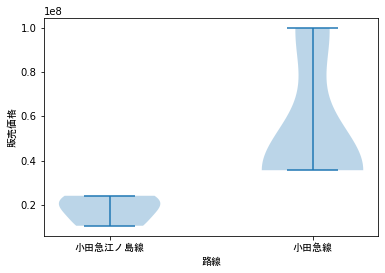

In [23]:
#小田急沿線と販売価格
x1 = df[df["沿線"] == '小田急江ノ島線']["販売価格"].values.tolist()
x2 = df[df["沿線"] == '小田急線']["販売価格"].values.tolist()

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot([x1, x2])
ax.set_xticks([1, 2])
ax.set_xticklabels(['小田急江ノ島線', '小田急線'], fontname="MS Gothic")
ax.set_xlabel("路線", fontname="MS Gothic")
ax.set_ylabel('販売価格', fontname="MS Gothic")
plt.show()

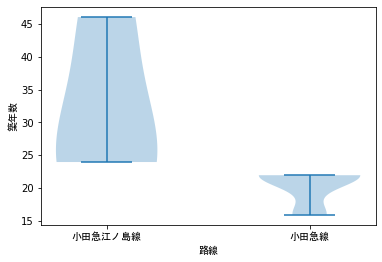

In [24]:
#小田急沿線と築年数
x1 = df[df["沿線"] == '小田急江ノ島線']["築年数"].values.tolist()
x2 = df[df["沿線"] == '小田急線']["築年数"].values.tolist()

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot([x1, x2])
ax.set_xticks([1, 2])
ax.set_xticklabels(['小田急江ノ島線', '小田急線'], fontname="MS Gothic")
ax.set_xlabel("路線", fontname="MS Gothic")
ax.set_ylabel('築年数', fontname="MS Gothic")
plt.show()

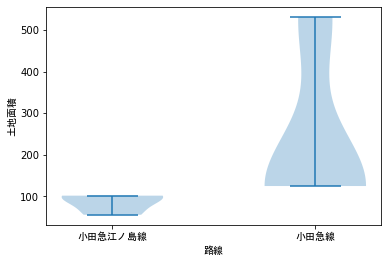

In [25]:
#小田急沿線と土地面積
x1 = df[df["沿線"] == '小田急江ノ島線']["土地面積"].values.tolist()
x2 = df[df["沿線"] == '小田急線']["土地面積"].values.tolist()

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot([x1, x2])
ax.set_xticks([1, 2])
ax.set_xticklabels(['小田急江ノ島線', '小田急線'], fontname="MS Gothic")
ax.set_xlabel("路線", fontname="MS Gothic")
ax.set_ylabel('土地面積', fontname="MS Gothic")
plt.show()

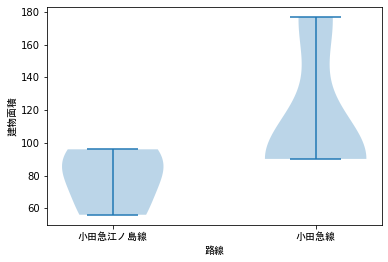

In [26]:
#小田急沿線と建物面積
x1 = df[df["沿線"] == '小田急江ノ島線']["建物面積"].values.tolist()
x2 = df[df["沿線"] == '小田急線']["建物面積"].values.tolist()

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot([x1, x2])
ax.set_xticks([1, 2])
ax.set_xticklabels(['小田急江ノ島線', '小田急線'], fontname="MS Gothic")
ax.set_xlabel("路線", fontname="MS Gothic")
ax.set_ylabel('建物面積', fontname="MS Gothic")
plt.show()

***2つのヴァイオリンプロットから分かること***  
- 小田急江ノ島線沿線の方が築年数が大きい、販売価格が安い、土地面積が小さい 、建物面積が小さい 
- 小田急線沿線の方が築年数は小さい、販売価格が高い、土地面積が大きい、建物面積が大きい  
小田急江ノ島線沿いには中古一戸建て物件が多く、小田急線沿いには中古マンション物件が多いといえそう。

In [106]:
df["販売価格"].head

<bound method NDFrame.head of 0        16800000
1        17500000
2        18800000
3        19800000
4        19800000
          ...    
8649     52900000
8650     64800000
8651     68800000
8652    149800000
8653    600000000
Name: 販売価格, Length: 8654, dtype: int64>

In [105]:
df["築年数"].dtypes
#df["販売価格"].dtypes

dtype('int64')

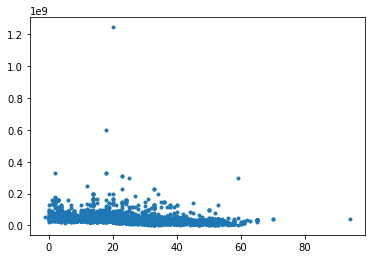

In [114]:
plt.scatter(df["築年数"], df["販売価格"], marker='.')

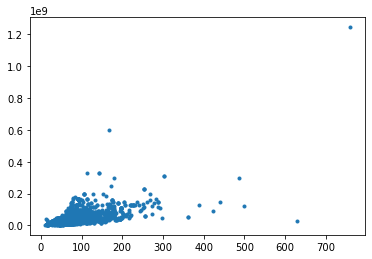

In [117]:
plt.scatter(df["建物面積"], df["販売価格"], marker='.')

In [13]:
set(df["沿線"])

{'JR京浜東北線',
 'JR南武線',
 'JR埼京線',
 'JR東海道本線',
 'JR根岸線',
 'JR横浜線',
 'JR横須賀線',
 'JR鶴見線',
 'みなとみらい線',
 'グリーンライン',
 'シーサイドライン',
 'ブルーライン',
 '京急本線',
 '京急逗子線',
 '小田急江ノ島線',
 '小田急線',
 '市営バス',
 '東急こどもの国線',
 '東急バス',
 '東急東横線',
 '東急田園都市線',
 '東急目黒線',
 '東海道新幹線',
 '横浜市営バス',
 '湘南新宿ライン',
 '相鉄いずみ野線',
 '相鉄新横浜線',
 '相鉄本線',
 '神奈中バス',
 '神奈川中央交通'}

In [102]:
set(df["築年数"])

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 65,
 70,
 94}

In [19]:
route = ['JR京浜東北線',
 'JR南武線',
 'JR埼京線',
 'JR東海道本線',
 'JR根岸線',
 'JR横浜線',
 'JR横須賀線',
 'JR鶴見線',]
floor_plan = ['55LDK',
 '5DK',
 '5K',
 '5LDK',
 '6DK',
 '6LDK',
 '7DK',
 '7LDK',
 '8LDK',
 '9LDK']
filtered = df[df["沿線"].isin(route) & df["間取り"].isin(floor_plan)]

C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36009 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22770 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20385 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22303 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22320 missing from c

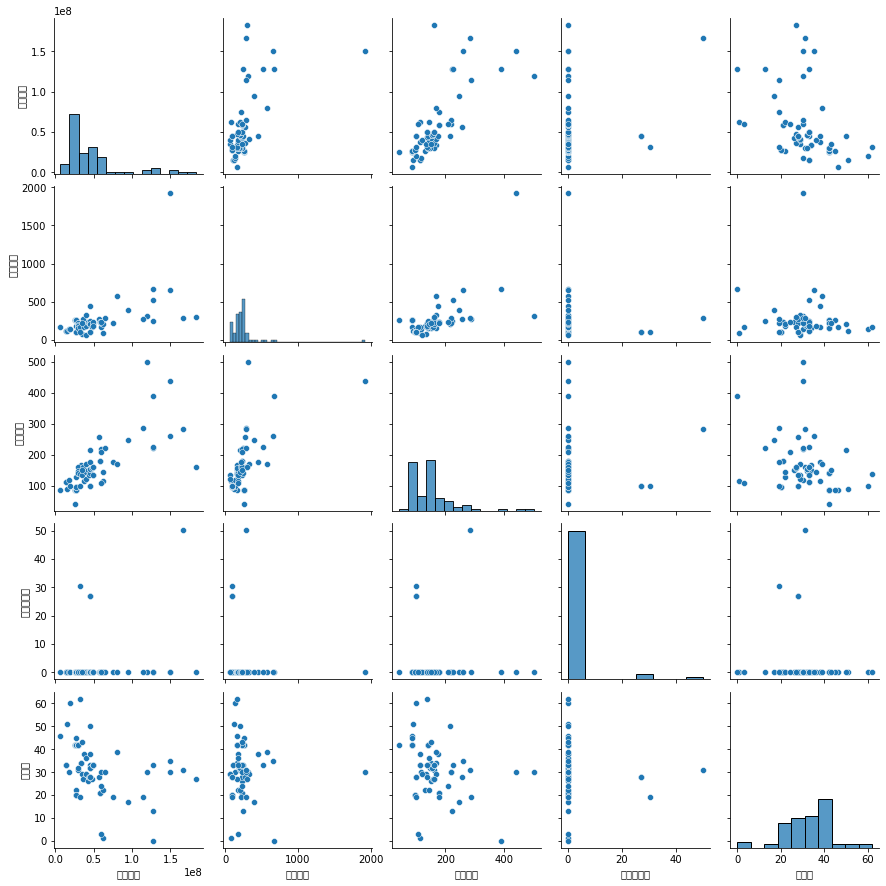

In [30]:
sns.pairplot(filtered)
plt.show()

In [32]:
import matplotlib
print(matplotlib.matplotlib_fname())

C:\Users\karin\anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlibrc


C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36009 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22770 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20385 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 36009 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\karin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22770 missing from cur

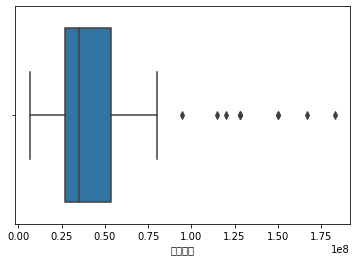

In [33]:
sns.boxplot(x='販売価格', data=filtered)
plt.show()

In [112]:
filtered.describe()

,販売価格,土地面積,建物面積,バルコニー,築年数
count,8.300000e+01,83.000000,83.000000,83.000000,83.000000
mean,4.881928e+07,247.991446,150.572048,1.618916,32.698795
std,3.644040e+07,216.925313,76.677458,7.544517,11.340339
min,7.000000e+06,62.010000,42.230000,0.000000,0.000000
25%,2.680000e+07,164.500000,95.580000,0.000000,27.000000
50%,3.480000e+07,225.390000,142.520000,0.000000,33.000000
75%,5.330000e+07,259.960000,164.370000,0.000000,42.000000
max,1.830000e+08,1920.360000,500.320000,50.100000,62.000000
